**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions.

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random
import matplotlib.pyplot as plt

##**Part 1. Building a CNN**

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

### **Q1.1**

According to the information provided in the above cell and the question:

1 batch = 32 examples

60,000 x 0.8 = 48,000 training examples

48,000 / 32 = 1,500 iterations

1,500 * 30 = 45,000 iterations

It would take 1,500 iteration to go through the entire training set given the number of examples yielded by the data split. In 30 epochs, there would be 45,000 interations.

In [ ]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
model.vars();

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns.



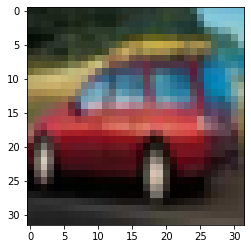

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output.

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

### **Q1.2**

In the cell below is my code for implementing my custom convolutional filter and when provided the same image and filter weights as the Objax convolutional layer, I obtain the same results.

In [ ]:
def my_conv_net(my_image, initial_filter_weights):
  #n = number of examples in a batch 32
  #c = number of channels/colors 3
  #h = height 32
  #w = width 32

  #height of output image
  H_out = my_image.shape[2] - initial_filter_weights.shape[0] + 1
  #width of output image
  W_out = my_image.shape[3] - initial_filter_weights.shape[1] + 1

  my_conv_output = np.zeros([my_image.shape[0], initial_filter_weights.shape[3], H_out, W_out])

  for n in range(my_conv_output.shape[0]): #n = 1
    for cout in range(my_conv_output.shape[1]): #cout = 0 1
      for i in range(my_conv_output.shape[2]): #i = 0 - 31
        for j in range(my_conv_output.shape[3]): #j = 0 -31
          my_conv_output[n, cout, i, j] = np.multiply(my_image[n,:, i, j], initial_filter_weights[:,:,:,cout]).sum()
  return my_conv_output

my_conv_output = my_conv_net(my_image, filter_weights)
print(my_conv_output)
print(my_conv_output.shape)


[[[[-0.10271907 -0.10010862 -0.09076816 ... -0.74204231 -0.73912485
    -0.73746224]
   [-0.12882357 -0.11180527 -0.11687266 ... -0.7310544  -0.74346105
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911371 -0.71740328
    -0.71560835]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.1117876  -0.11439805
    -0.1222294 ]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353442 -0.08614487 ... -0.16399661 -0.16138616
    -0.15355481]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253252  0.7320599
     0.72146261]
   [ 0.14844203  0.12636711  0.1275416  ...  0.77934483  0.7626404
     0.75807608]
   [ 0.15300635  0.12562042  0.15036321 ...  0.79253835  0.77845234
     0.77533194]
   ...
   [ 0.20083014  0.1917015   0.1917015  ...  0.27218535  0.27674967
     0.29044263]
   [ 0.16887989  0.15975125  0.15975125 ...  0.29957127  0.29500695
     0.29500695]
   [ 0.15062261  0.14605828  0.15062261 ...  0.3634

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer.

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388902]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.**



### **Q1.3**

In the following cell, I have writen out the linear layer using Objax.nn.Linear function as well as my own custom Linear layer. As you can see in it's output, my custom Linear Layer obtains the same result as the objax linear layer.

In [ ]:
#OBJAX LINEAR LAYER:
x = my_conv_output.mean((2,3))

objax_lin_layer = objax.nn.Linear(x.shape[1], 1)
y = objax_lin_layer(x)
w = objax_lin_layer.w.value
b = objax_lin_layer.b.value

#OWN LINEAR LAYER:
my_y = np.sum(np.multiply(w.T, x)) + b[0]

print(y)
print(my_y)

[[0.03471544]]
0.034715448


### **Q1.4**

The training set is used to determine and improve the parameters of the model, such as the weight and biases. The validation set is used to fine tune the hyperparameters of the model, such as the polynomial degree of the model that best fits the data without over/under-fitting.

##**Part 2. Training and Tuning a CNN**
The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

### **Q2.1**
Answer in train_op function.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      #QUESTION 2.1#
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

### **Q2.2**
Answer inside train() function.

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          #Question 2.2#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          #Question 2.2#
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

### **Q2.3**
The following cell contains the training of the base model, along with the evaluation and plots of the training loss, validation loss, training accuracy and validation accuracy.

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

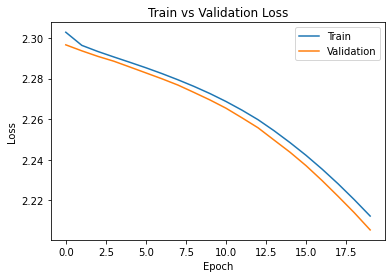

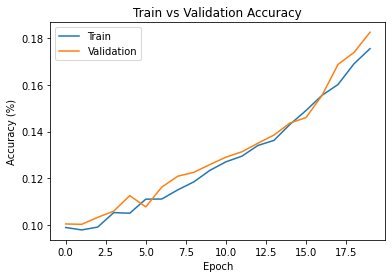

In [ ]:
train()

### **Q2.4**
Hyperparameters are parameters that must be initially set by the user before training a model in order to control the capacity of the model. For example, the penality for the misclassification of datapoints in an SVM model is a hyperparameter.

It is important to not evaluate the accuracy of the test set unitl all hyperparameters have been tuned because the accuracy of the test set measures the generalizability of the model to new, unseen data. If we were to evaluate the accuracy of the test set without having finalized the hyperparameters of the model, we risk overfitting our hyperparameters - and consequently our model - to the training, validation and test sets. This would ultimately decrease our model's generalizability to new data.



### **Q2.5**
Chosen Hyperparameters:

*   Epochs
*   Batch Size
*   Learning Rate
*   Number of Outputs of Convolutional Layer 1

H1 = {Epochs = 25, Batch Size = 100, Learning Rate = 0.1, Layer 1 Output = 8}

H2 = {Epochs = 20, Batch Size = 5, Learning Rate = 0.001, Layer 1 Output = 20}

### **Q2.6**

The following cells include two newly trained models M1_model and M2_model which have varying hyperparameters as described in the previous question.
Each model is also provids a set of plots displaying the trend of the training loss, validation loss, training accuracy and validation accuracy.


#### M1_model:

Epoch 0001  Training Loss 2.22 Validation Loss 2.11 Training Accuracy 17.73 Validation Accuracy 20.63
Epoch 0002  Training Loss 2.09 Validation Loss 2.05 Training Accuracy 23.48 Validation Accuracy 25.30
Epoch 0003  Training Loss 2.04 Validation Loss 1.99 Training Accuracy 26.12 Validation Accuracy 26.12
Epoch 0004  Training Loss 1.98 Validation Loss 2.02 Training Accuracy 29.11 Validation Accuracy 24.55
Epoch 0005  Training Loss 1.93 Validation Loss 1.93 Training Accuracy 31.09 Validation Accuracy 27.52
Epoch 0006  Training Loss 1.89 Validation Loss 1.84 Training Accuracy 33.01 Validation Accuracy 31.93
Epoch 0007  Training Loss 1.86 Validation Loss 1.82 Training Accuracy 33.88 Validation Accuracy 33.32
Epoch 0008  Training Loss 1.83 Validation Loss 1.79 Training Accuracy 34.81 Validation Accuracy 33.87
Epoch 0009  Training Loss 1.81 Validation Loss 1.79 Training Accuracy 36.00 Validation Accuracy 34.15
Epoch 0010  Training Loss 1.80 Validation Loss 1.75 Training Accuracy 36.76 Valida

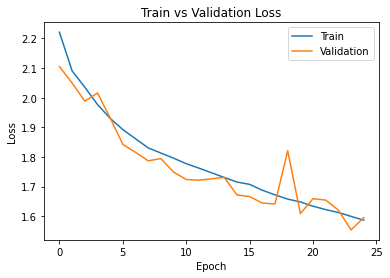

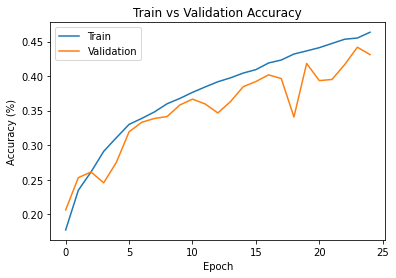

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)
  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x
M1_model = ConvNet()

def loss_function(x, labels):
    logit = M1_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(M1_model(x)), M1_model.vars())
gv= objax.GradValues(loss_function, M1_model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in M1_model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS=25, BATCH=100, LEARNING_RATE=0.1)

#### M2_model

Epoch 0001  Training Loss 2.26 Validation Loss 2.22 Training Accuracy 15.27 Validation Accuracy 17.88
Epoch 0002  Training Loss 2.18 Validation Loss 2.14 Training Accuracy 19.90 Validation Accuracy 19.90
Epoch 0003  Training Loss 2.12 Validation Loss 2.10 Training Accuracy 21.74 Validation Accuracy 21.88
Epoch 0004  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 23.18 Validation Accuracy 22.68
Epoch 0005  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 24.24 Validation Accuracy 24.05
Epoch 0006  Training Loss 2.06 Validation Loss 2.05 Training Accuracy 25.11 Validation Accuracy 25.02
Epoch 0007  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 25.96 Validation Accuracy 25.72
Epoch 0008  Training Loss 2.04 Validation Loss 2.02 Training Accuracy 27.00 Validation Accuracy 25.70
Epoch 0009  Training Loss 2.02 Validation Loss 2.01 Training Accuracy 27.59 Validation Accuracy 27.57
Epoch 0010  Training Loss 2.00 Validation Loss 1.99 Training Accuracy 28.69 Valida

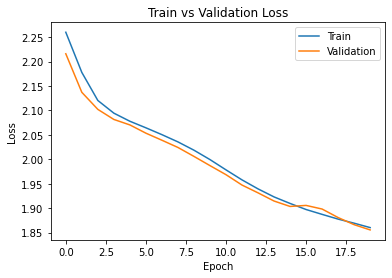

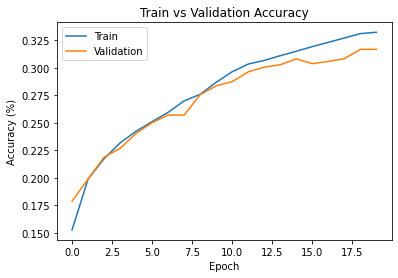

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 20, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(20, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)
  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x
M2_model = ConvNet()

def loss_function(x, labels):
    logit = M2_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(M2_model(x)), M2_model.vars())
gv= objax.GradValues(loss_function, M2_model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in M2_model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS=20, BATCH=5, LEARNING_RATE=0.001)

#### **Analysis of Base, M1 and M2 models.**
As previously mentioned the hyperparameters used in this question are as follows.

Base Model : Epochs = 20, Batch Size = 32, Learning Rate = 0.0009, Number of Output of Convolutional Layer 1 = 16.

M1_model : Epcochs = 25, Batch Size = 100, Learning Rate = 0.01, Number of Output of Convolutional Layer 1 = 8.

M2_model : Epochs = 20, Batch Size = 5, Learning Rate = 0.001, Number of Output of Convolutional Layer 1 = 20.


The base model achieves it's highest validation accuracy of 18.27% at EPOCH 20. The M1_model achieves a validation accuracy of 41.83% at EPOCH 20 and it's highest validation accuracy of 44.18% at epoch 24. The M2_model achieves it's highest validation accuracy of 31.68% at EPOCH 19.

Therefore, the M1_model performs the best in terms of validation accuracy.

### **Q2.7**

Based on the validation accuracy provided in the previous question, I should choose my M1_model but run it for more epochs. The following cells run this model on the test set. The final test accuracy of this model is reported beneath the below plots.

Epoch 0001  Training Loss 2.22 Test Loss 2.12 Training Accuracy 17.51 Test Accuracy 21.42
Epoch 0002  Training Loss 2.10 Test Loss 2.11 Training Accuracy 23.18 Test Accuracy 21.72
Epoch 0003  Training Loss 2.06 Test Loss 2.04 Training Accuracy 25.88 Test Accuracy 24.60
Epoch 0004  Training Loss 2.01 Test Loss 1.98 Training Accuracy 28.11 Test Accuracy 26.03
Epoch 0005  Training Loss 1.97 Test Loss 1.96 Training Accuracy 29.89 Test Accuracy 25.30
Epoch 0006  Training Loss 1.93 Test Loss 1.88 Training Accuracy 31.51 Test Accuracy 31.20
Epoch 0007  Training Loss 1.90 Test Loss 1.85 Training Accuracy 32.51 Test Accuracy 30.52
Epoch 0008  Training Loss 1.87 Test Loss 1.83 Training Accuracy 33.66 Test Accuracy 31.88
Epoch 0009  Training Loss 1.85 Test Loss 1.81 Training Accuracy 34.46 Test Accuracy 32.28
Epoch 0010  Training Loss 1.83 Test Loss 1.81 Training Accuracy 35.45 Test Accuracy 34.38
Epoch 0011  Training Loss 1.80 Test Loss 1.77 Training Accuracy 36.51 Test Accuracy 33.65
Epoch 0012

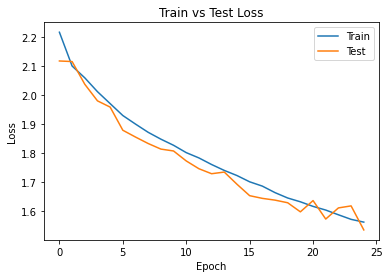

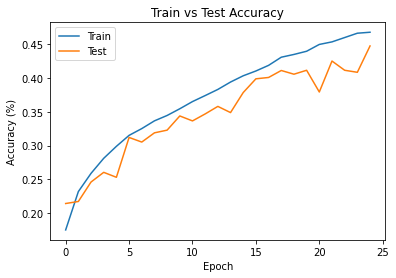

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)
  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x
M1_model = ConvNet()

def loss_function(x, labels):
    logit = M1_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(M1_model(x)), M1_model.vars())
gv= objax.GradValues(loss_function, M1_model.vars())
tv = objax.ModuleList(objax.TrainRef(x) for x in M1_model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def test_train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_test_loss_epoch = []
  train_acc_epoch = []
  test_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_test_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      test_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)

      for it in range(0, X_train.shape[0], BATCH):
          #Question 2.2#
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      test_indices = np.arange(len(X_test))
      np.random.shuffle(test_indices)
      for it in range(0, X_test.shape[0], BATCH):
          batch = test_indices[it:it+BATCH]
          avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          test_prediction = predict(X_test[batch]).argmax(1)
          test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      test_acc_epoch.append(test_acc/X_test.shape[0])
      avg_test_loss_epoch.append(avg_test_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Test Loss %.2f Training Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_test_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*test_acc/X_test.shape[0]))

  #Plot training loss
  plt.title("Train vs Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_test_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(test_acc_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

test_train(EPOCHS=25, BATCH=100, LEARNING_RATE=0.1)

The final test accuracy of my M1_model is 44.75% at epoch 25.

##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


### **Q3.1**
Import and partitioning the cifar100 dataset.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(3)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

169017344/169001437 [==============================] - 6s 0us/step


### **Q3.2**
Creating and Training a Base Model.

In [ ]:
#Question 2: create base model
class myConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = x.mean((2,3))
    x = self.linear(x)
    return x

base_model = myConvNet()

In [ ]:
def loss_function(x, labels):
    logit = base_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(base_model(x)), base_model.vars())

gv= objax.GradValues(loss_function, base_model.vars())

tv = objax.ModuleList(objax.TrainRef(x) for x in base_model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 100, LEARNING_RATE = 9e-2):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.22 Validation Accuracy 1.23
Epoch 0002  Training Loss 4.59 Validation Loss 4.57 Training Accuracy 1.25 Validation Accuracy 1.47
Epoch 0003  Training Loss 4.53 Validation Loss 4.48 Training Accuracy 1.81 Validation Accuracy 2.70
Epoch 0004  Training Loss 4.43 Validation Loss 4.38 Training Accuracy 3.25 Validation Accuracy 3.13
Epoch 0005  Training Loss 4.36 Validation Loss 4.34 Training Accuracy 4.31 Validation Accuracy 3.40
Epoch 0006  Training Loss 4.31 Validation Loss 4.29 Training Accuracy 5.04 Validation Accuracy 3.98
Epoch 0007  Training Loss 4.27 Validation Loss 4.26 Training Accuracy 5.99 Validation Accuracy 5.10
Epoch 0008  Training Loss 4.24 Validation Loss 4.22 Training Accuracy 6.57 Validation Accuracy 4.98
Epoch 0009  Training Loss 4.21 Validation Loss 4.21 Training Accuracy 6.95 Validation Accuracy 5.93
Epoch 0010  Training Loss 4.19 Validation Loss 4.18 Training Accuracy 7.51 Validation Accuracy 6.53


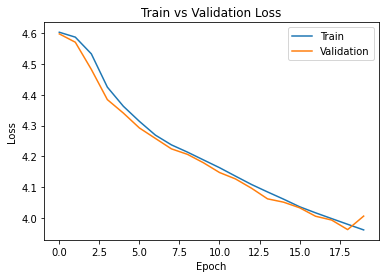

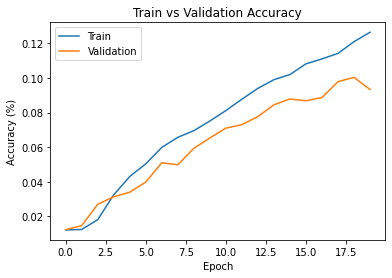

In [ ]:
train()

### **Q3.3**
I chose to tune the following hyperparameters:     

* Learning Rate
* Batch Size
* Number of Convolutional Layers

The following cells contained this new tune_model and it's training output. Beneath it's plots, is a succinct discusion on my design procedure.

In [ ]:
class myConvNet2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
    x = x.mean((2,3))
    x = self.linear(x)
    return x

tune_model = myConvNet2()

Epoch 0001  Training Loss 4.58 Validation Loss 4.52 Training Accuracy 1.89 Validation Accuracy 1.93
Epoch 0002  Training Loss 4.43 Validation Loss 4.36 Training Accuracy 3.56 Validation Accuracy 3.27
Epoch 0003  Training Loss 4.34 Validation Loss 4.32 Training Accuracy 5.05 Validation Accuracy 3.83
Epoch 0004  Training Loss 4.26 Validation Loss 4.23 Training Accuracy 6.59 Validation Accuracy 4.93
Epoch 0005  Training Loss 4.19 Validation Loss 4.15 Training Accuracy 7.80 Validation Accuracy 5.90
Epoch 0006  Training Loss 4.13 Validation Loss 4.08 Training Accuracy 9.34 Validation Accuracy 8.07
Epoch 0007  Training Loss 4.06 Validation Loss 4.00 Training Accuracy 11.19 Validation Accuracy 8.75
Epoch 0008  Training Loss 3.96 Validation Loss 3.92 Training Accuracy 13.01 Validation Accuracy 10.85
Epoch 0009  Training Loss 3.87 Validation Loss 3.78 Training Accuracy 14.95 Validation Accuracy 12.70
Epoch 0010  Training Loss 3.79 Validation Loss 3.74 Training Accuracy 15.97 Validation Accuracy

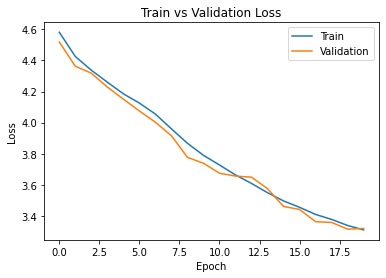

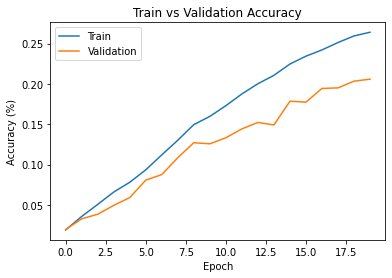

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = tune_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(tune_model(x)), tune_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, tune_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in tune_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

train(EPOCHS = 20, BATCH = 125, LEARNING_RATE = 0.1)

This new model was inspired by some of the hyperparameter tuning that occured in part 2 of this assignment. From part 2 I realised that a bigger batch size decreased the amount of time needed to train the model and that the bigger batch size coupled with the increased learning rate resulted in a higher validation accuracy. But for this model I also decided to add another convolution layer in hopes of also increasing the accuracy.

My base model obtained a validation accuracy of 12.15% at epoch 19.

My tuned model obtained a validation accuracy of 21.53% at epoch 19.

Which is a 9.38% increase in validation accuracy.

### **Q3.4**

My final model will be the second tune_model defined in question 3.3. The following cell test and reports the accuracy of the model with respect to the test set.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = tune_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(tune_model(x)), tune_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, tune_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in tune_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def test_train(EPOCHS = 20, BATCH = 100, LEARNING_RATE = 9e-2):
  avg_train_loss_epoch = []
  avg_test_loss_epoch = []
  train_acc_epoch = []
  test_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_test_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      test_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      test_indices = np.arange(len(X_test))
      np.random.shuffle(test_indices)
      for it in range(0, X_test.shape[0], BATCH):
          batch = test_indices[it:it+BATCH]
          avg_test_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          test_prediction = predict(X_test[batch]).argmax(1)
          test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
      test_acc_epoch.append(test_acc/X_test.shape[0])
      avg_test_loss_epoch.append(avg_test_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Test Loss %.2f Training Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_test_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*test_acc/X_test.shape[0]))

  #Plot training loss
  plt.title("Train vs Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_test_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(test_acc_epoch, label="test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 3.25 Test Loss 3.34 Training Accuracy 27.77 Test Accuracy 19.77
Epoch 0002  Training Loss 3.22 Test Loss 3.36 Training Accuracy 28.36 Test Accuracy 19.80
Epoch 0003  Training Loss 3.19 Test Loss 3.23 Training Accuracy 29.11 Test Accuracy 21.80
Epoch 0004  Training Loss 3.17 Test Loss 3.21 Training Accuracy 29.38 Test Accuracy 22.17
Epoch 0005  Training Loss 3.15 Test Loss 3.21 Training Accuracy 29.93 Test Accuracy 22.75
Epoch 0006  Training Loss 3.11 Test Loss 3.18 Training Accuracy 30.56 Test Accuracy 23.03
Epoch 0007  Training Loss 3.10 Test Loss 3.20 Training Accuracy 30.91 Test Accuracy 22.13
Epoch 0008  Training Loss 3.07 Test Loss 3.16 Training Accuracy 31.44 Test Accuracy 23.92
Epoch 0009  Training Loss 3.06 Test Loss 3.25 Training Accuracy 31.80 Test Accuracy 22.13
Epoch 0010  Training Loss 3.04 Test Loss 3.11 Training Accuracy 32.20 Test Accuracy 24.30
Epoch 0011  Training Loss 3.01 Test Loss 3.13 Training Accuracy 32.99 Test Accuracy 23.93
Epoch 0012

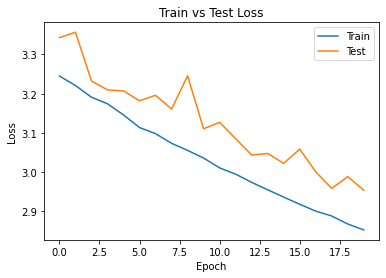

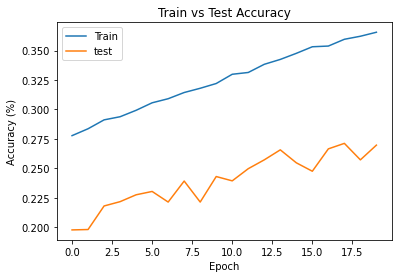

In [ ]:
test_train(EPOCHS=20, BATCH=125, LEARNING_RATE=0.1)

From the previous cell, the best test accuracy of the improved tune_model is 27.12% at epoch 18.

##**Problem 4. Open-Ended Exploration**

For Part 4 of this assignment I have chosen to answer question 2, in which I demonstrate for at least two hyperparameters that independantly they improve the model accuracy and together they also improve the model accuracy. I have chosen to build upon the model and datasets used in Part 1 and Part 2 of this assignment.

In the following cells I will :
1. Copy and re-use the base model an associate functions and re-print the results obtained in part 2.
2. Then I will train the first model in which I will tune the **batch size** hyperparameter and train the model while printing the results.
3. Then I will train the second model in which I will tune the **learning rate** hyperparameter and train the model while printing the results.
4. I wil then combine the tuned hyperparameters into a single model and train it.
5. I will select the best model based on it's performance and use it on the test set.

This procedure differs from that used in part 2 of the assignment because in part 2 I was changing multiple parameters at once and hoping that it improves the accuracy of the model. So, although I may be tuning hyperparameters already seen, I will be able to truly identify exactly how much changing these hyperparameters affects the model.

### **Base Model**

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

model = ConvNet()

In [ ]:
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

gv= objax.GradValues(loss_function, model.vars())

tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)
    for grad, params in zip(gradient, tv.vars()):
      params.assign(params.value - lr*grad)
    return loss_value

train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0
      avg_val_loss =  0
      train_acc = 0
      val_acc = 0

      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

### **Base Model : Orginal Batch Size and Learning Rate**
The following cell contains the training and validation accuracy of the base model when trained with it's original hyperparameters : Batch Size = 32 and Learning Rate = 0.0009.

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

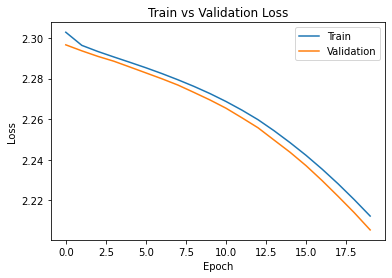

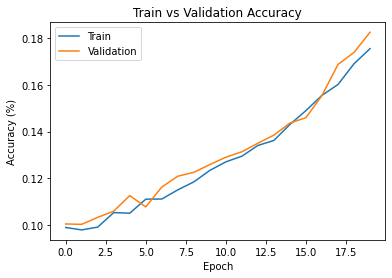

In [ ]:
train()

### **Model 1 : Hyperparameter Batch Size**
In order to determine how the Batch size affects the accuracy of the model I will increase it from 32 (base model) to 64 (model 1).

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.90 Validation Accuracy 10.22
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.83 Validation Accuracy 9.98
Epoch 0003  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.77 Validation Accuracy 10.03
Epoch 0004  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.82 Validation Accuracy 10.05
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.82 Validation Accuracy 10.03
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.99 Validation Accuracy 10.30
Epoch 0007  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.00 Validation Accuracy 10.35
Epoch 0008  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.14 Validation Accuracy 10.55
Epoch 0009  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.32 Validation Accuracy 10.88
Epoch 0010  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.54 Validation Ac

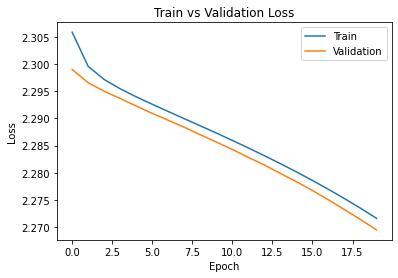

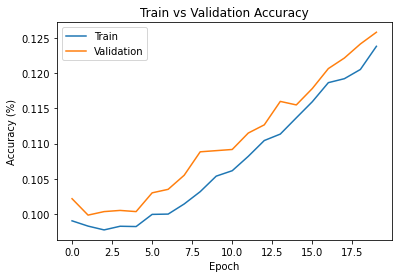

In [ ]:
train(EPOCHS=20, BATCH=64, LEARNING_RATE=0.0009)

By observing the validation accuracy of the model when the batch size is increased, I realised that increasing the batch size significantly decreases the validation accuracy.

Base model: 18.27% at epoch 20.

Model 1: 12.58% at epoch 20.

So I decided to tune (retrain) model 1 with a smaller batch size of 16.

Epoch 0001  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.79 Validation Accuracy 10.00
Epoch 0002  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.14 Validation Accuracy 10.80
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 10.93 Validation Accuracy 11.32
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.77 Validation Accuracy 12.12
Epoch 0005  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.48 Validation Accuracy 13.18
Epoch 0006  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 13.26 Validation Accuracy 13.87
Epoch 0007  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 13.72 Validation Accuracy 14.27
Epoch 0008  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 14.64 Validation Accuracy 16.28
Epoch 0009  Training Loss 2.23 Validation Loss 2.22 Training Accuracy 15.85 Validation Accuracy 17.88
Epoch 0010  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 17.69 Validat

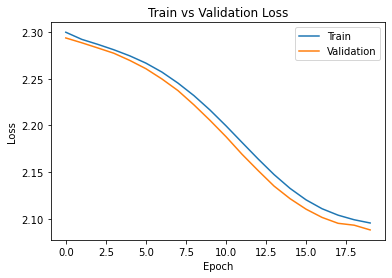

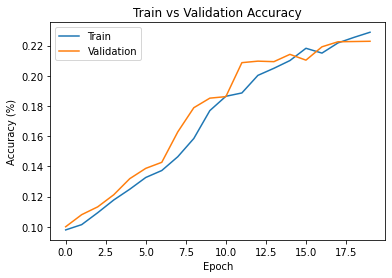

In [ ]:
train(EPOCHS=20, BATCH=16,LEARNING_RATE=0.0009)

Retraining model 1 with a batch size of 16 increased the validation accuracy.

Base Model : 18.27% at epoch 20

Model 1: 22.28% at epoch 20.

I did not fine the increase in validation accuracy (4.01%) to be large enough so I retrained model 1 again with an even smaller batch size of 8.

Epoch 0001  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 10.08 Validation Accuracy 10.72
Epoch 0002  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.42 Validation Accuracy 12.47
Epoch 0003  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 13.07 Validation Accuracy 13.20
Epoch 0004  Training Loss 2.25 Validation Loss 2.24 Training Accuracy 15.18 Validation Accuracy 15.80
Epoch 0005  Training Loss 2.22 Validation Loss 2.21 Training Accuracy 16.94 Validation Accuracy 17.92
Epoch 0006  Training Loss 2.19 Validation Loss 2.17 Training Accuracy 18.88 Validation Accuracy 20.32
Epoch 0007  Training Loss 2.16 Validation Loss 2.14 Training Accuracy 20.72 Validation Accuracy 19.58
Epoch 0008  Training Loss 2.13 Validation Loss 2.11 Training Accuracy 21.31 Validation Accuracy 21.15
Epoch 0009  Training Loss 2.11 Validation Loss 2.10 Training Accuracy 22.13 Validation Accuracy 22.47
Epoch 0010  Training Loss 2.10 Validation Loss 2.09 Training Accuracy 22.84 Valida

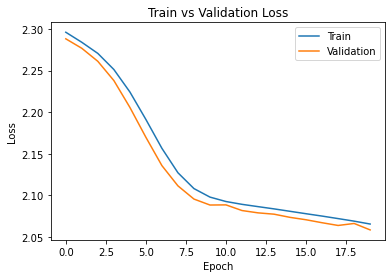

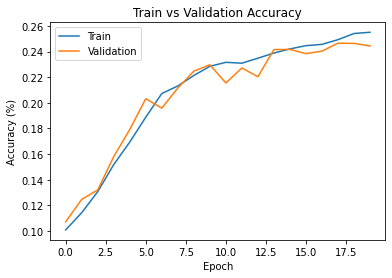

In [ ]:
train(EPOCHS=20, BATCH=8, LEARNING_RATE=0.0009)

Finaly, the validation accuracy was improved significantly be reducing the batch size from 32 (base model) to 8 (model 1, final retrain).

Base Model : 18.27% at epoch 20.
Model 1: 24.43% at epoch 20.

The validation accuracy increased by 6.16%, which is not much larger than the previous model, so I deduced that any further decrease in batch size would not significantly affect the validation accuracy.

### **Model 2: Hyperparameter Learning Rate**
Following the same procedure as detailed in model 1, I will be training a second model in order to tune the learning rate hyperparameter.

The base model has a learning rate of 0.0009, and it's testing and validation accuracy is detailed in the cells above.

I will first start by decreasing the learning rate to 0.0001 and observing how it affects the validation accuracy of the base model (while keeping the orginial batch size of 32).

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.94 Validation Accuracy 10.25
Epoch 0002  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.92 Validation Accuracy 10.25
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.90 Validation Accuracy 10.25
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.22
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.17
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.83 Validation Accuracy 10.03
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.81 Validation Accuracy 10.05
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.79 Validation Accuracy 10.02
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.79 Validation Accuracy 9.98
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.75 Validation Accura

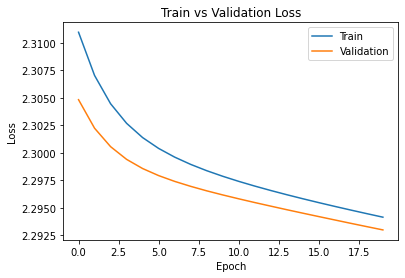

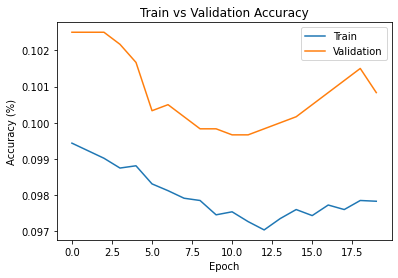

In [ ]:
train(EPOCHS=20, BATCH=32, LEARNING_RATE=0.0001)

According to the previous cell, decreasing the learning rate so significantly acctually decreased the validation accuracy of the model.

Base Model : 18.27% at epoch 20

Model 2: 10.08% at epoch 20.

In order to improve this model, and tune the learning rate hyperparameter, I have decided to increase the learning rate from 0.0009 (base model) to 0.009 (model 2).

Epoch 0001  Training Loss 2.29 Validation Loss 2.26 Training Accuracy 14.16 Validation Accuracy 14.42
Epoch 0002  Training Loss 2.21 Validation Loss 2.15 Training Accuracy 17.59 Validation Accuracy 21.48
Epoch 0003  Training Loss 2.12 Validation Loss 2.09 Training Accuracy 21.15 Validation Accuracy 21.73
Epoch 0004  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.24 Validation Accuracy 21.65
Epoch 0005  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 22.77 Validation Accuracy 23.13
Epoch 0006  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 23.42 Validation Accuracy 23.67
Epoch 0007  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 23.80 Validation Accuracy 24.87
Epoch 0008  Training Loss 2.06 Validation Loss 2.04 Training Accuracy 24.60 Validation Accuracy 25.03
Epoch 0009  Training Loss 2.04 Validation Loss 2.03 Training Accuracy 25.13 Validation Accuracy 26.07
Epoch 0010  Training Loss 2.03 Validation Loss 2.01 Training Accuracy 26.46 Valida

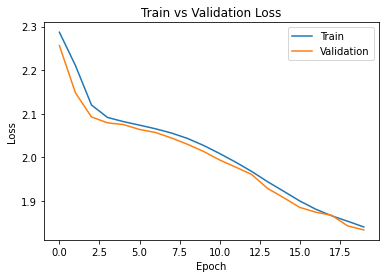

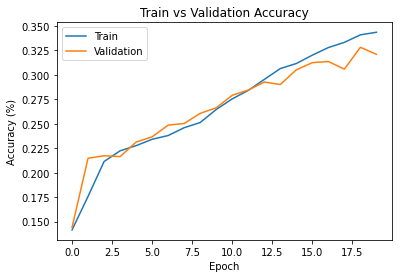

In [ ]:
train(EPOCHS=20, BATCH=32, LEARNING_RATE=0.009)

As seen above, increasing the learning rate from 0.0009 to 0.009 significantly improve the validation accuracy of the model.

Base Model: 18.27% at epoch 20.

Model 2: 32.10% at epoch 20.

Which is a 13.83% increase in validation accuracy.

The following model, Model 3, will combine the two previously tuned hyperparameters and allow me to evaluate how they affect the training model together.

### **Model 3: Tuned Batch Size and Learning Rate**

The following model will be trained with a batch size of 8 and a learning rate of 0.009, on the validation set.


Epoch 0001  Training Loss 2.21 Validation Loss 2.10 Training Accuracy 18.32 Validation Accuracy 20.33
Epoch 0002  Training Loss 2.09 Validation Loss 2.07 Training Accuracy 24.09 Validation Accuracy 23.07
Epoch 0003  Training Loss 2.05 Validation Loss 2.02 Training Accuracy 26.31 Validation Accuracy 26.22
Epoch 0004  Training Loss 1.99 Validation Loss 1.96 Training Accuracy 30.03 Validation Accuracy 28.60
Epoch 0005  Training Loss 1.92 Validation Loss 1.89 Training Accuracy 33.58 Validation Accuracy 30.18
Epoch 0006  Training Loss 1.86 Validation Loss 1.84 Training Accuracy 36.04 Validation Accuracy 32.22
Epoch 0007  Training Loss 1.83 Validation Loss 1.83 Training Accuracy 37.24 Validation Accuracy 31.73
Epoch 0008  Training Loss 1.81 Validation Loss 1.79 Training Accuracy 38.50 Validation Accuracy 32.20
Epoch 0009  Training Loss 1.78 Validation Loss 1.76 Training Accuracy 39.65 Validation Accuracy 35.92
Epoch 0010  Training Loss 1.75 Validation Loss 1.74 Training Accuracy 40.86 Valida

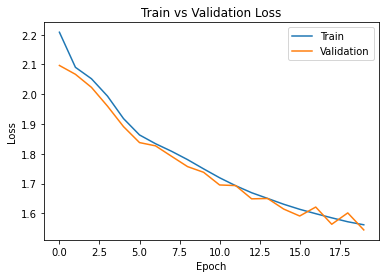

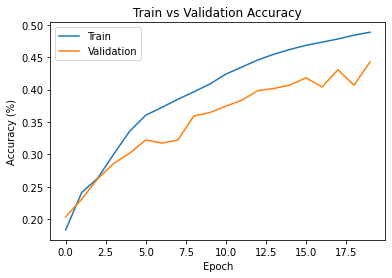

In [ ]:
train(EPOCHS=20, BATCH=8, LEARNING_RATE=0.009)

As seen above, combining the improved batch size and learning rate increase the validation accuracy of the model significantly.

Base Model (no tuning) : 18.27% at epoch 20.

Model 1 (tuned batch size): 24.43% at epoch 20.

Model 2 (tuned learning rate) : 33.15% at epoch 20.

Model 3 (combined hyperparameter): 44.27% at epoch 20.

The model with the best performance with respect to the validation accuracy is model 3. As such I will be using this model on the test set.

#### **Model 3: on the Test Set**
The following cell defines a function that will 'train' the model on both the training and test set.

In [ ]:
def test_train(EPOCHS = 20, BATCH = 8, LEARNING_RATE = 9e-3):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0
      avg_val_loss =  0
      train_acc = 0
      val_acc = 0

      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      val_indices = np.arange(len(X_test))
      np.random.shuffle(val_indices)
      for it in range(0, X_test.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_test[batch], Y_test[batch])) * len(batch)
          val_prediction = predict(X_test[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_test[batch]).sum()
      val_acc_epoch.append(val_acc/X_test.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_test.shape[0])

      print('Epoch %04d  Training Loss %.2f Test Loss %.2f Training Accuracy %.2f Test Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_test.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_test.shape[0]))

  plt.title("Train vs Test Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Test Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Test")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 1.84 Test Loss 1.81 Training Accuracy 37.39 Test Accuracy 31.65
Epoch 0002  Training Loss 1.80 Test Loss 1.76 Training Accuracy 38.97 Test Accuracy 35.32
Epoch 0003  Training Loss 1.77 Test Loss 1.77 Training Accuracy 40.04 Test Accuracy 35.33
Epoch 0004  Training Loss 1.75 Test Loss 1.77 Training Accuracy 41.08 Test Accuracy 34.27
Epoch 0005  Training Loss 1.73 Test Loss 1.73 Training Accuracy 42.23 Test Accuracy 35.95
Epoch 0006  Training Loss 1.71 Test Loss 1.73 Training Accuracy 43.36 Test Accuracy 36.53
Epoch 0007  Training Loss 1.68 Test Loss 1.66 Training Accuracy 43.92 Test Accuracy 39.02
Epoch 0008  Training Loss 1.66 Test Loss 1.65 Training Accuracy 44.91 Test Accuracy 39.57
Epoch 0009  Training Loss 1.64 Test Loss 1.63 Training Accuracy 45.96 Test Accuracy 40.75
Epoch 0010  Training Loss 1.63 Test Loss 1.63 Training Accuracy 46.73 Test Accuracy 39.37
Epoch 0011  Training Loss 1.61 Test Loss 1.64 Training Accuracy 47.70 Test Accuracy 40.63
Epoch 0012

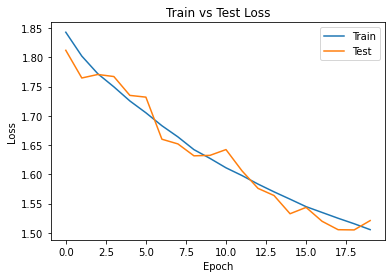

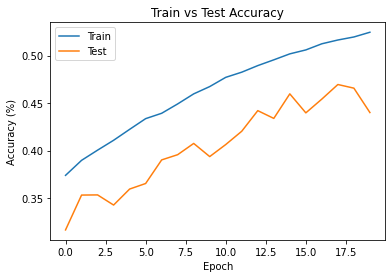

In [ ]:
test_train()

As seen above, the final performance on the test set in a test accuracy of 44.00% at epoch 20, which is slighly less than the 44.27% validation accuracy, and is to be expected.

### **Q4 - In detail**
Throughout the process of tuning the models, I have written out multiple textboxes that explain and keep track of the progress of the validation accuracy throughout this exploration, but I will succintly re-explain everything here.

**Question 4.1**

I chose to answer question 2 : "How do hyperparameters interact?"

I decided to tune the Batch Size and Learning Rate hyperparameters.

I tried 3 models : the base model, model 1: batch size tuning and model 2: learning rate tuning and I repeatedly trained models 1 and 2 until the validation accuracy improved to my satisfaction.

Essentially, the base model's hyperparameters were set to a batch size of 32 and a learning rate of 0.0009. This provided a baseline validation accuracy of 18.27% to which I compared the performace of the other models.

For model 1:   
* I first set the batch size equal to 64, which is two times the batch size of the base model. I hypothesized that a larger batch size would improve the model's accuracy. This was proven incorrect when the validation accuracy at epoch 20 decrease to 12.58%.
* I then set the batch size equal to 16, which is half the batch size of the base model. The validation accuracy of this model improved to 22.28% at epoch 20. This was only slighly greater than the base model validation accuracy.
* I then decided to train the model again with a batch size of 8, which is a quarter of the size of the base model. The validation accuracy of this model improved to 24.43%, which was larger than the previous attempt but not significantly enough that I found there to be any reason to continue to tune this hyperparameter.

I then moved on to model 2 which tuned the learning rate hyperparameter.

For model 2:     
* I first decreased the learning rate to 0.0001, on the same order of magnitude as the learning rate of the base model but significantly smaller. I predicted that a smaller learning rate would improve the accuracy of the model as it would take smaller steps in gradient descent. I was proven incorrect when the validation accuracy of this model decreased to 10.08% at epoch 20.
* I then decided to move in the other direction and increase the learning rate to 0.009, which is ten times the learning rate of the base model. This significantly increased the validation accuracy of the model to 32.10% at epoch 20.

At this point, I have demonstrated how two hyperparameters could be tuned individually to improve the overall performance of the model. I then trained a final model 3 that combined the now improved hyperparameters. Model 3 obtained a validation accuracy of 44.27% at epoch 20, which is significantly larger than that of the base model, model 1 and model 2.

I chose  my final model based on the performance (validation accuracy) of all the models I trained.  

**Question 4.2:**

I chose model 3 as my final model because it had the best performance (validation accuracy) out of all the models I trained.

When I ran this final model on the test dataset I obtained a final test accuracy of 44.0%; which was less than the validation accuracy of the final model but greater than the validation accuracy of all the other model I trained, as expected.